In [2]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2
import random
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, concatenate
import tensorflow_addons as tfa
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from keras.layers import BatchNormalization

In [27]:
df = pd.read_csv('../input/diabetic-retinopathy-224x224-gaussian-filtered/train.csv')
df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

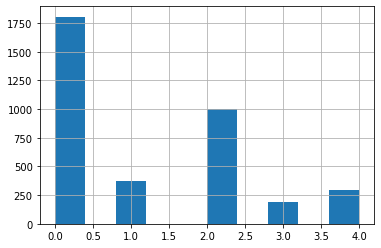

In [28]:
df['diagnosis'].hist()
df['diagnosis'].value_counts()

In [4]:
diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,type
0,000c1434d8d7,2,Moderate
1,001639a390f0,4,Proliferate_DR
2,0024cdab0c1e,1,Mild
3,002c21358ce6,0,No_DR
4,005b95c28852,0,No_DR


In [5]:
def merge_value(data):
    if data==1 or data==2 or data==3 or data==4:
        return np.int64(1)
    else:
        return np.int64(0)

In [6]:
df['diagnosis'] = df['diagnosis'].apply(merge_value)

In [7]:
diagnosis_dict_btype = {
    0: 'No_DR',
    1: 'DR'
}
df['b_type'] = df['diagnosis'].map(diagnosis_dict_btype.get)
df.head()

,id_code,diagnosis,type,b_type
0,000c1434d8d7,1,Moderate,DR
1,001639a390f0,1,Proliferate_DR,DR
2,0024cdab0c1e,1,Mild,DR
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


In [8]:
df.head()

,id_code,diagnosis,type,b_type
0,000c1434d8d7,1,Moderate,DR
1,001639a390f0,1,Proliferate_DR,DR
2,0024cdab0c1e,1,Mild,DR
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


1    1857
0    1805
Name: diagnosis, dtype: int64

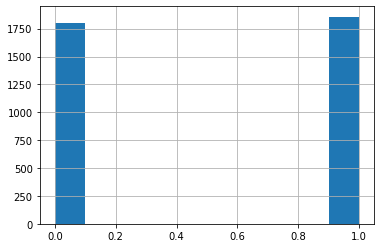

In [9]:
df['diagnosis'].hist()
df['diagnosis'].value_counts()

In [10]:
train_intermediate, val = train_test_split(df, test_size = 0.2)
train, test = train_test_split(train_intermediate, test_size = 0.2 / (1 - 0.2))

print(train['diagnosis'].value_counts(), '\n')
print(test['diagnosis'].value_counts(), '\n')
print(val['diagnosis'].value_counts(), '\n')

1    1116
0    1080
Name: diagnosis, dtype: int64 

1    383
0    350
Name: diagnosis, dtype: int64 

0    375
1    358
Name: diagnosis, dtype: int64 



In [11]:
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [12]:
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [13]:
src_dir = '../input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['b_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['b_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)
 
for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['b_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

In [14]:
def image_preproc(image):
    image = cv2.resize(image,(224,224))
    image= tf.image.adjust_contrast(image, 0.6)
    image = tfa.image.equalize(image)
    return image

In [15]:
train_path = './train'
val_path = './val'
test_path = './test'

train_batches = ImageDataGenerator(rescale = 1./255,preprocessing_function=image_preproc).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255,preprocessing_function=image_preproc).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255,preprocessing_function=image_preproc).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

Found 2196 images belonging to 2 classes.
Found 733 images belonging to 2 classes.
Found 733 images belonging to 2 classes.


In [16]:
from tensorflow.keras.callbacks import EarlyStopping

2021-12-09 07:15:06.563112: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-09 07:15:06.676132: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-09 07:15:06.676834: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-09 07:15:06.679049: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


<Figure size 432x288 with 0 Axes>

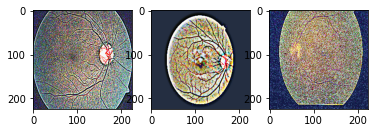

In [17]:
plt.figure()
f, axarr = plt.subplots(1,3)
for i in range (0,3):
    random_num = random.randint(0,40)
    image = train_batches[random_num]
    axarr[i].imshow(image[0][0])
    print(np.shape(image[0][0]))

In [18]:
cnn_model = tf.keras.Sequential()
cnn_model.add(Conv2D(16, (3, 3),activation='relu',input_shape=(224,224, 3)))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Conv2D(32, (3, 3),activation='relu'))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Conv2D(64, (3, 3),activation='relu'))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Conv2D(256, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(BatchNormalization())
cnn_model.add(Flatten())
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(1024, activation='relu'))
cnn_model.add(Dense(2, activation='softmax'))

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])
history = cnn_model.fit_generator(train_batches,
                    epochs=60,
                    validation_data=val_batches,callbacks=EarlyStopping(monitor="val_loss", patience=5, 
                    restore_best_weights=True))

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/60


2021-12-09 07:15:17.626056: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


69/69 [==============================] - 34s 396ms/step - loss: 0.4665 - acc: 0.8279 - val_loss: 0.6695 - val_acc: 0.8022
Epoch 2/60
69/69 [==============================] - 27s 387ms/step - loss: 0.2887 - acc: 0.8957 - val_loss: 0.6396 - val_acc: 0.8827
Epoch 3/60
69/69 [==============================] - 27s 393ms/step - loss: 0.2372 - acc: 0.9089 - val_loss: 0.5981 - val_acc: 0.8799
Epoch 4/60
69/69 [==============================] - 27s 385ms/step - loss: 0.2123 - acc: 0.9180 - val_loss: 0.5404 - val_acc: 0.8922
Epoch 5/60
69/69 [==============================] - 27s 395ms/step - loss: 0.1980 - acc: 0.9221 - val_loss: 0.4671 - val_acc: 0.9113
Epoch 6/60
69/69 [==============================] - 27s 388ms/step - loss: 0.1844 - acc: 0.9317 - val_loss: 0.3909 - val_acc: 0.9181
Epoch 7/60
69/69 [==============================] - 27s 397ms/step - loss: 0.1766 - acc: 0.9358 - val_loss: 0.3211 - val_acc: 0.9263
Epoch 8/60
69/69 [==============================] - 27s 392ms/step - loss: 0.168

<AxesSubplot:>

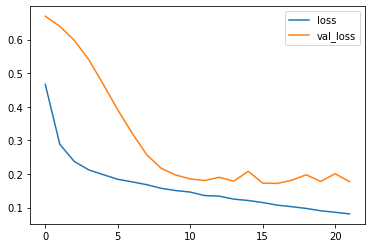

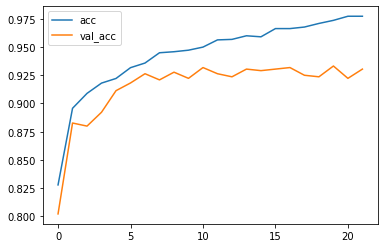

In [19]:
import json
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

In [ ]:
cnn_model.save('Standard_CNN_Updated1.h5')

In [20]:
from tensorflow.keras.models import load_model
savedModel=load_model('../input/standard-model/Standard_CNN_Updated1.h5')

In [21]:
test_eval = savedModel.evaluate(test_batches)
print(f'test loss, test acc: {test_eval}')

23/23 [==============================] - 7s 289ms/step - loss: 0.1092 - accuracy: 0.9659
test loss, test acc: [0.10918046534061432, 0.965893566608429]


In [22]:
predictions = savedModel.predict(test_batches)

In [23]:
from sklearn.metrics import confusion_matrix,classification
from sklearn.metrics import classification_report

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [24]:
y_pred=predictions.argmax(axis=1)
y_true = test_batches.labels

In [26]:
print(confusion_matrix(y_pred,y_true))
print("\n\n")
print(classification_report(y_pred,y_true))

[[369  11]
 [ 14 339]]



              precision    recall  f1-score   support

           0       0.96      0.97      0.97       380
           1       0.97      0.96      0.96       353

    accuracy                           0.97       733
   macro avg       0.97      0.97      0.97       733
weighted avg       0.97      0.97      0.97       733

